In [1]:
import sys
sys.path.append('../')

In [3]:
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import nltk

from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

from wordcloud import WordCloud, STOPWORDS

from src.exploratory_data_analysis import Wordcloud, SentimentAnalyzer, gather_data
from src.embedding_visualizer import EmbeddingVisualizer

# Gather articles from 2023


In [4]:
full_df = gather_data(path='../data/2023_articles_en')

Remove articles without texts

In [3]:
full_df = full_df[full_df['text'] != 'None']

# Exploratory Data Analysis (EDA)

## Wordcloud of most common words across all articles

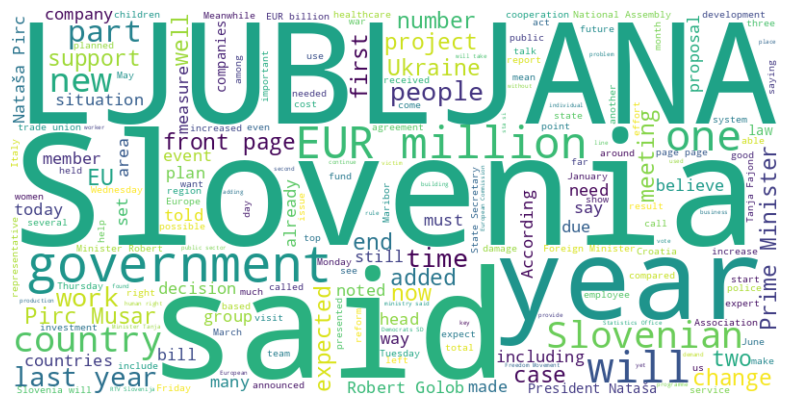

In [32]:
all_text = ' '.join(full_df['text'])
wordcloud = Wordcloud()
wordcloud.plot_wordcloud(all_text, title='Wordcloud of all articles')

## Outliers (with Ada embeddings)

All articles have been embedded with Ada embeddings from OpenAI API. 

They were generated with Large Language Models. They encode various semantic properties of the whole text fragment.

They have 1536 dimensions each.

We can use these to find outliers in the dataset (to catch and visualize articles that are in some semantic way different than others).

There are 3 outlier methods implemented: Local Outlier Factor, Isolation Forest and One Class SVM. The final outliers are computed as a cross-section of all 3 methods.

In [5]:
embeddings = full_df['ada_embedding'].apply(eval)
embeddings = np.array(embeddings.tolist())

In [6]:
# create local outlier factor model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

# create one class svm model
svm = OneClassSVM(nu=0.1, kernel='rbf', gamma=0.1)

# create isolation forest model
isolation_forest = IsolationForest(n_estimators=100, contamination=0.1)

# fit models
lof_outliers = np.where(lof.fit_predict(embeddings) == -1)[0]
svm_outliers = np.where(svm.fit_predict(embeddings) == -1)[0]
isolation_forest_outliers = np.where(isolation_forest.fit_predict(embeddings) == -1)[0]

In [7]:
common_outliers = np.intersect1d(lof_outliers, svm_outliers)
common_outliers = np.intersect1d(common_outliers, isolation_forest_outliers)

#### Word cloud for datapoints classified as outliers with Ada embeddings

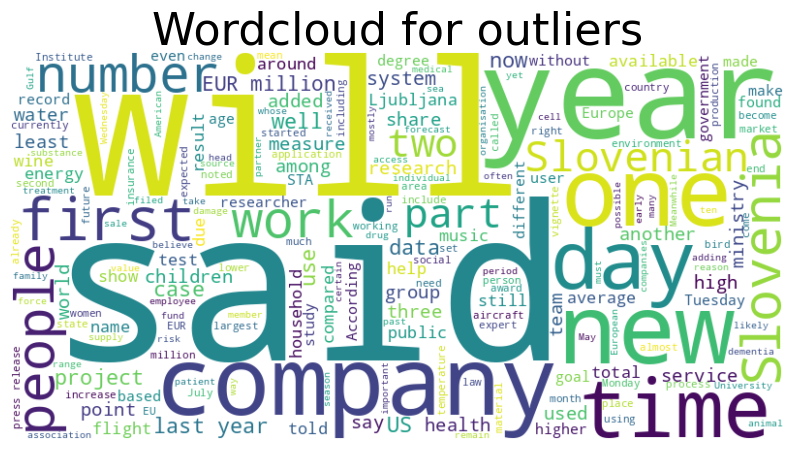

In [17]:
outlier_df = full_df.iloc[common_outliers]
all_text = ' '.join(outlier_df['text'])
wordcloud.plot_wordcloud(outlier_df, title='Wordcloud for outliers')

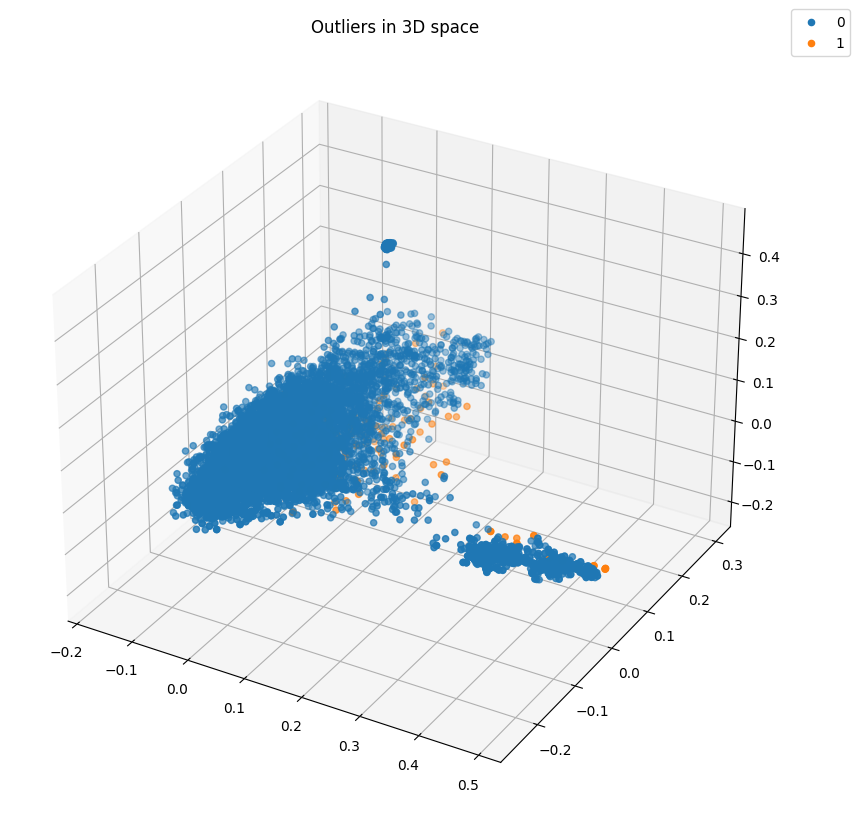

In [21]:
labels = [1 if i in common_outliers else 0 for i in range(len(embeddings))]
embedding_visualizer = EmbeddingVisualizer(embeddings=embeddings, labels=labels)
embedding_visualizer.visualize(dimension=3, method='pca', title='Outliers in 3D space')

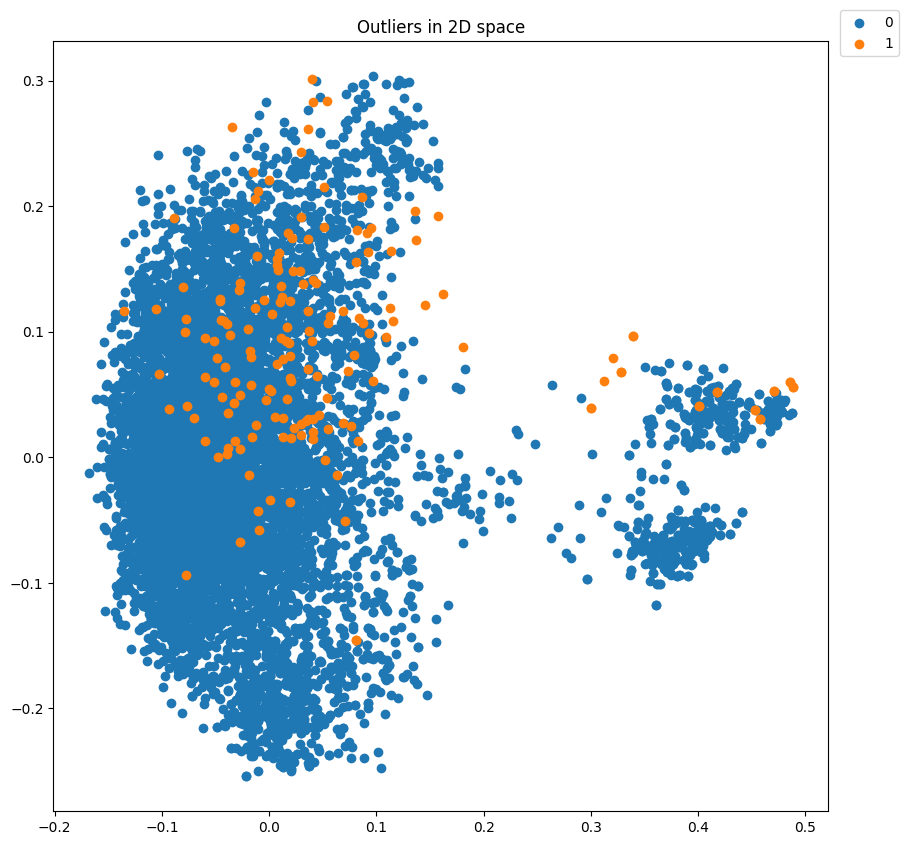

In [22]:
embedding_visualizer.visualize(dimension=2, method='pca', title='Outliers in 2D space')

## Outliers (with bert embeddings)

We execute the same steps as above but using less powerfull but cheaper embeddings from local BERT model.

The BERT model tends to be less powerfull when it comes to understanding of overall context of the text, but it focuses more on the meaning of individual words.

In [ ]:
embeddings = full_df['bert_embedding'].apply(eval)
embeddings = np.array(embeddings.tolist())

In [25]:
# create local outlier factor model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

# create one class svm model
svm = OneClassSVM(nu=0.1, kernel='rbf', gamma=0.1)

# create isolation forest model
isolation_forest = IsolationForest(n_estimators=100, contamination=0.1)

# fit models
lof_outliers = np.where(lof.fit_predict(embeddings) == -1)[0]
svm_outliers = np.where(svm.fit_predict(embeddings) == -1)[0]
isolation_forest_outliers = np.where(isolation_forest.fit_predict(embeddings) == -1)[0]

In [28]:
common_outliers = np.intersect1d(lof_outliers, svm_outliers)
common_outliers = np.intersect1d(common_outliers, isolation_forest_outliers)

#### Word cloud for datapoints classified as outliers with BERT embeddings

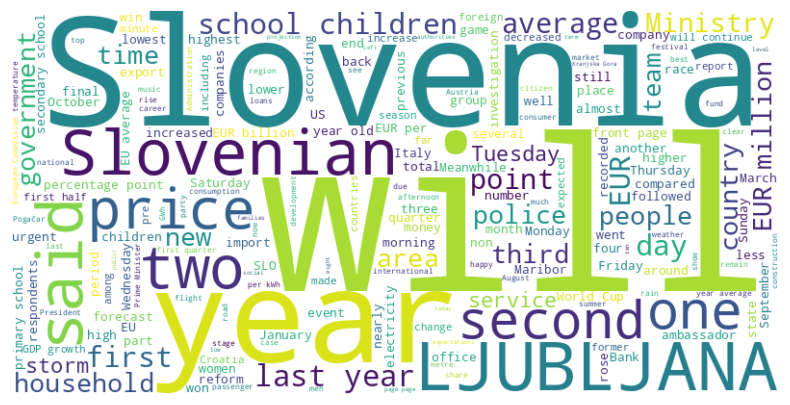

In [33]:
outlier_df = full_df.iloc[common_outliers]
all_text = ' '.join(outlier_df['text'])
wordcloud.plot_wordcloud(outlier_df, title='Wordcloud for outliers')

#### Visualization of outliers

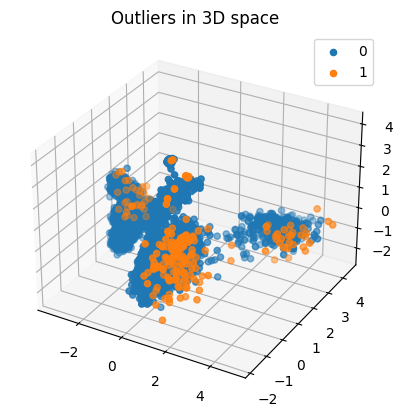

In [65]:
labels = [1 if i in common_outliers else 0 for i in range(len(embeddings))]
embedding_visualizer = EmbeddingVisualizer(embeddings=embeddings, labels=labels)
embedding_visualizer.visualize(dimension=3, method='pca', title='Outliers in 3D space')


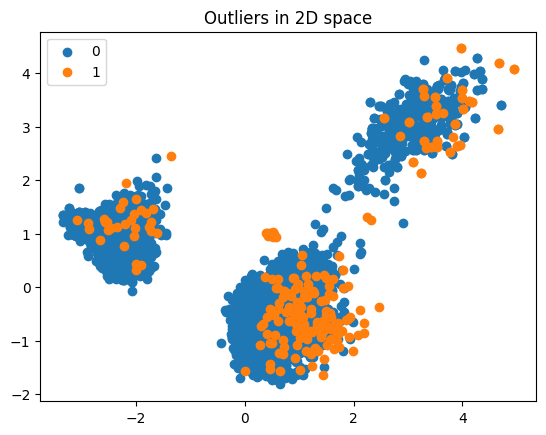

In [64]:
embedding_visualizer.visualize(dimension=2, method='pca', title='Outliers in 2D space')

c:\Users\jan20\PycharmProjects\PytorchProjects\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\jan20\PycharmProjects\PytorchProjects\venv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


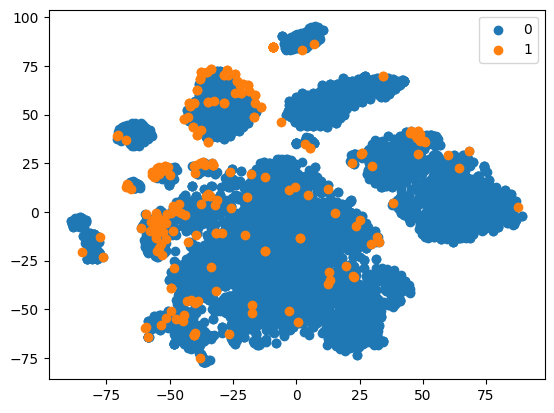

In [63]:
embedding_visualizer.visualize(dimension=2, method='tsne')

## Histogram of most frequent keywords provided in the dataset across all articles

In [13]:
keyword_dict = {}

for index, row in tqdm(full_df.iterrows()):

    keywords = row['keywords'][1:-1].split(',')
    for keyword in keywords:
        if keyword in keyword_dict.keys():
            keyword_dict[keyword] += 1
        else:
            keyword_dict[keyword] = 1

keyword_dict = {k: v for k, v in sorted(keyword_dict.items(), key=lambda item: item[1], reverse=True)}

8778it [00:00, 15195.93it/s]


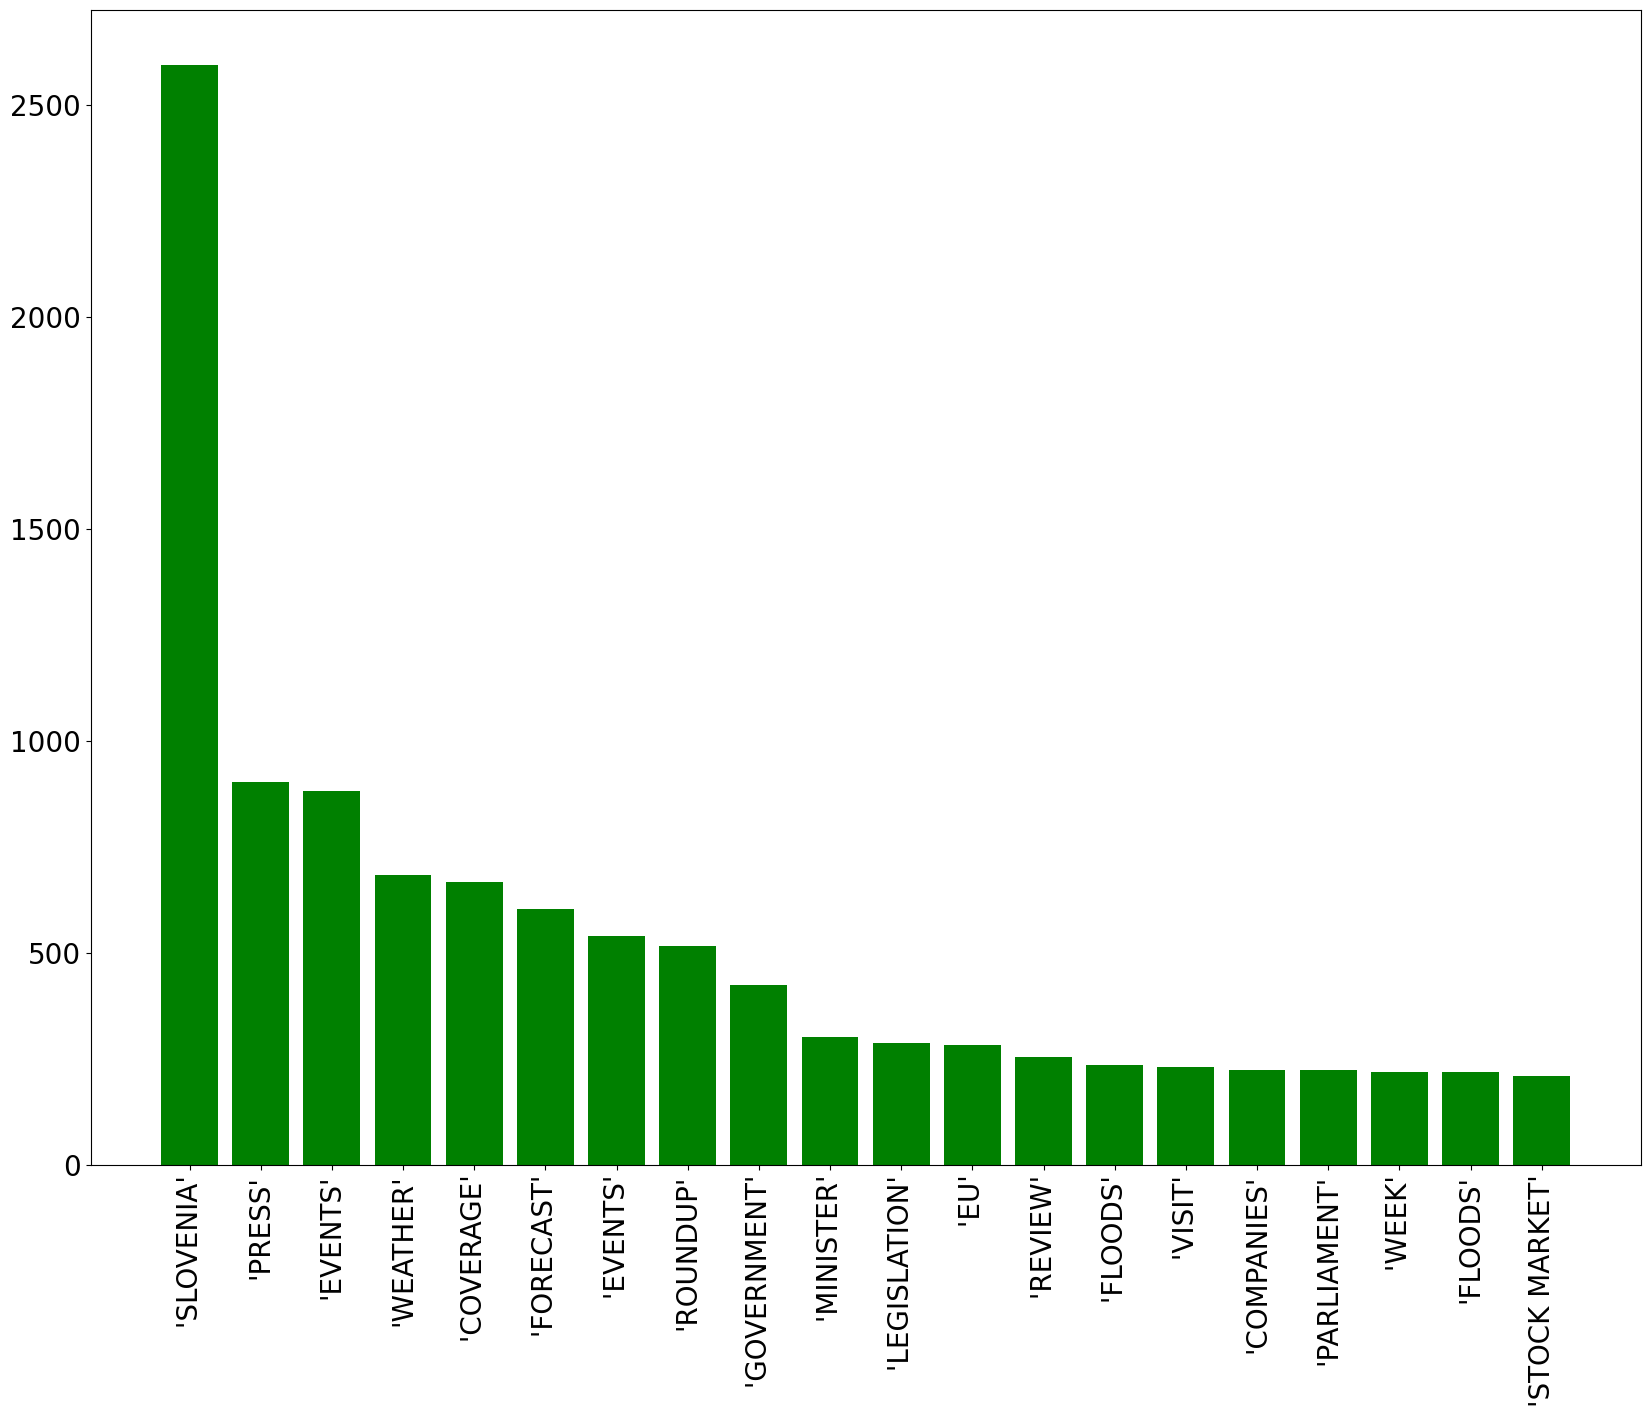

In [23]:
plt.figure(figsize=(20, 15))
plt.xticks(rotation=90)
plt.bar(list(keyword_dict.keys())[:20], list(keyword_dict.values())[:20], color='g')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

## Sentiment in different classes

We go over selected classes from our taxonomy, and compute their sentiment accross articles using nltk SentimentIntensityAnalyzer.

In [ ]:
sentiment_analyzer = SentimentAnalyzer()

full_df['sentiment'] = full_df['text'].apply(lambda x: sentiment_analyzer.get_vader_sentiment(x))

In [74]:
positive_df = full_df[full_df['sentiment'] >= 0]
negative_df = full_df[full_df['sentiment'] < 0]

In [73]:
def get_mean_sentiment_by_category(df):

    sentiment_dict = {}
    sentiment_dict_num = {}

    for index, row in tqdm(df.iterrows()):
        # create list from keywords
        for keyword in eval(row['categories']):
            if keyword in sentiment_dict.keys():
                sentiment_dict[keyword] += row['sentiment']
                sentiment_dict_num[keyword] += 1
            else:
                sentiment_dict[keyword] = row['sentiment']
                sentiment_dict_num[keyword] = 1
    # calculate mean sentiment for each category

    for key in sentiment_dict.keys():
        sentiment_dict[key] = sentiment_dict[key] / sentiment_dict_num[key]
    return sentiment_dict

In [ ]:
sentiment_dict = get_mean_sentiment_by_category(full_df)
positive_sentiment_dict = get_mean_sentiment_by_category(positive_df)
negative_sentiment_dict = get_mean_sentiment_by_category(negative_df)

In [58]:
label_map = {'PO': 'Politics',
             'SE': 'Schedule of Events and Sports',
             'BE': 'Business, Finance and Economy',
             'AS': 'Around Slovenia',
             'HE': 'Health, Environment and Science',
             'ST': 'Advisory',
             'AC': 'Arts and Culture',
             'RU': 'Roundup'
             }

In [85]:
def plot_sentiment(sentiment_dict):

    plt.figure(figsize=(12, 8))
    plt.xticks(rotation=90)
    plt.bar(list(sentiment_dict.keys()), list(sentiment_dict.values()), color='g')
    labels = [label_map[x] for x in list(sentiment_dict.keys())]
    plt.xticks(list(sentiment_dict.keys()), labels, fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel('Mean sentiment', fontsize=20)
    plt.show()



### On full dataframe

Plot of of overall average sentiment scores for each class

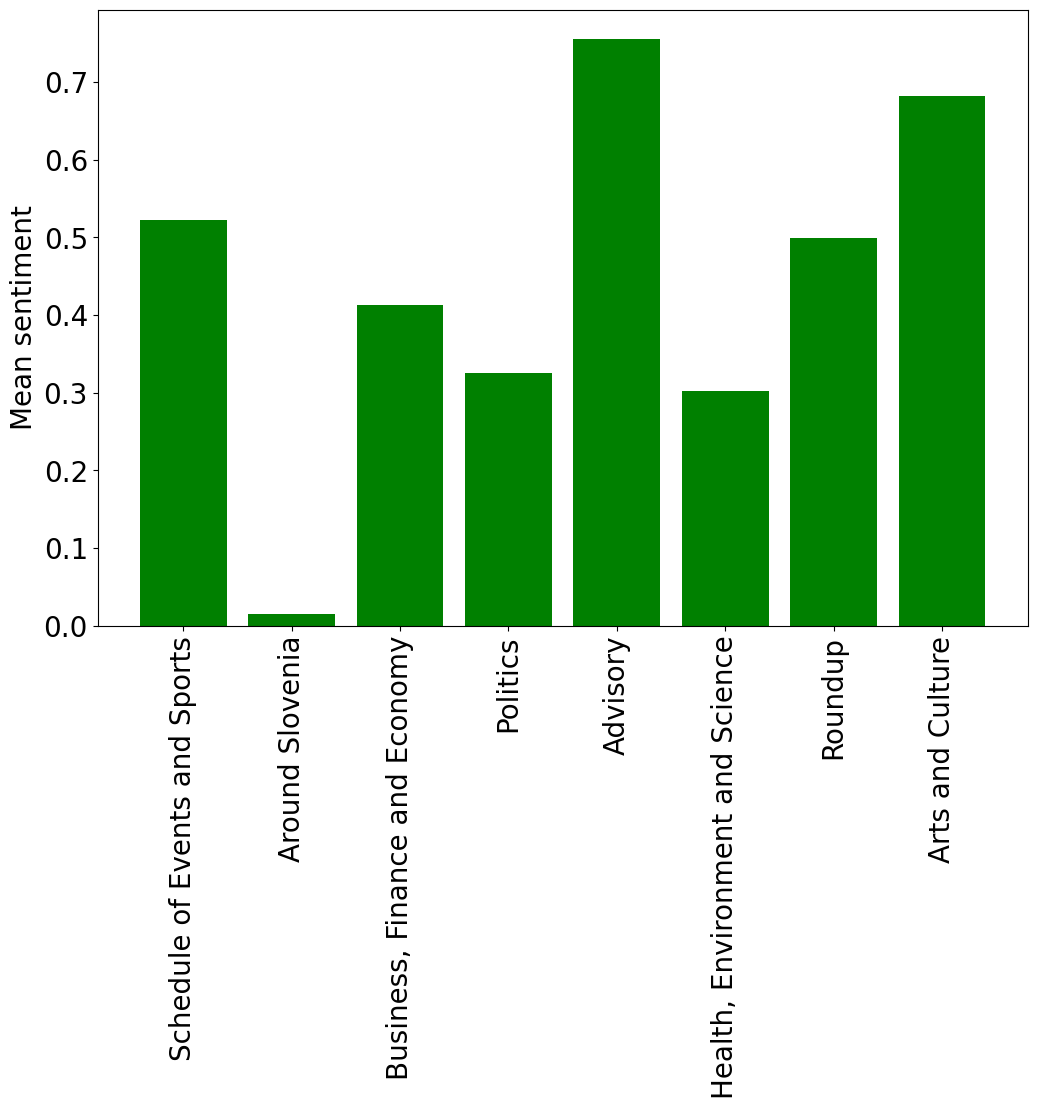

In [86]:
plot_sentiment(sentiment_dict)

### Only positive

Plot of of average sentiment scores for each class, but only for articles with positive sentiment

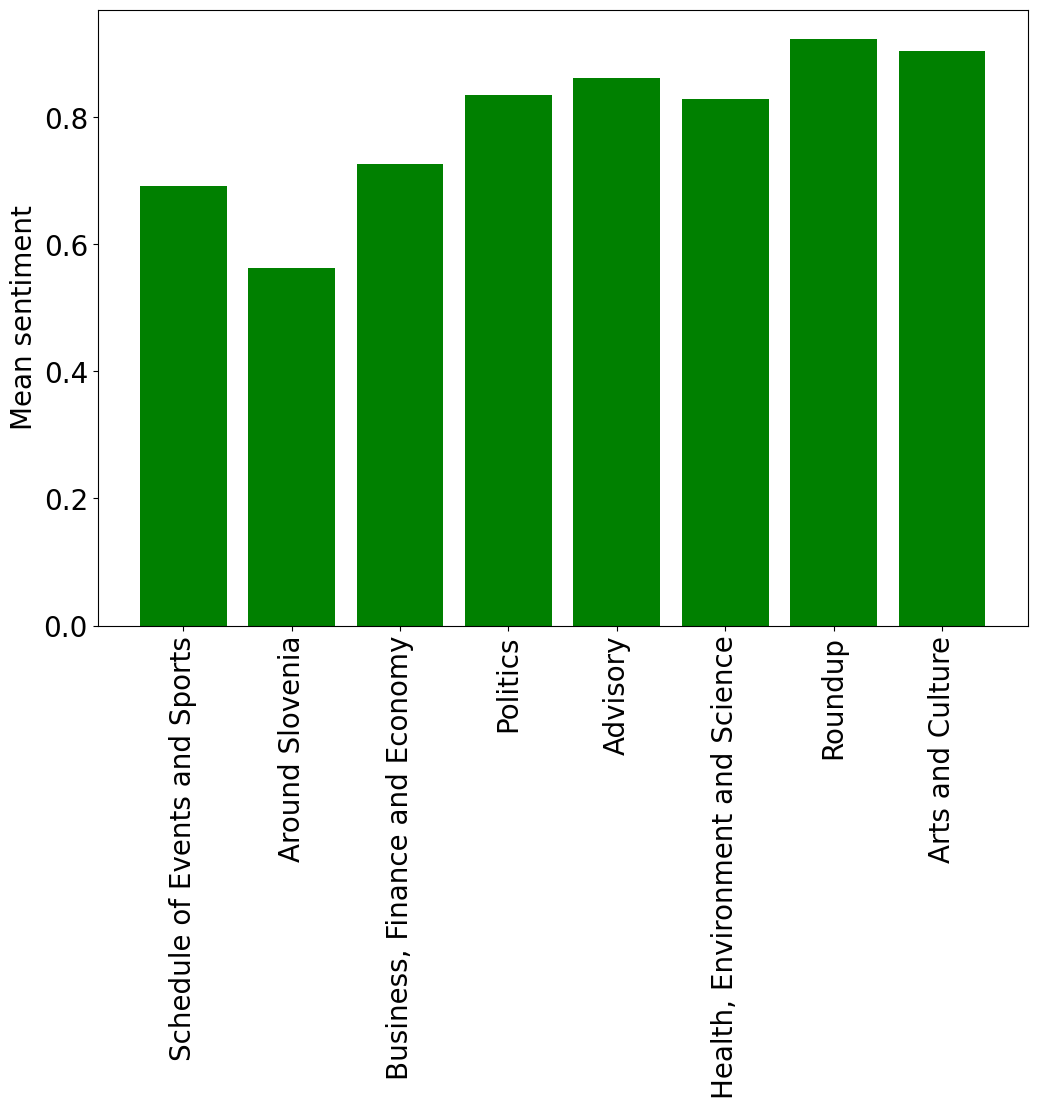

In [87]:
plot_sentiment(positive_sentiment_dict)

### Only negative

Plot of of average sentiment scores for each class, but only for articles with negative sentiment

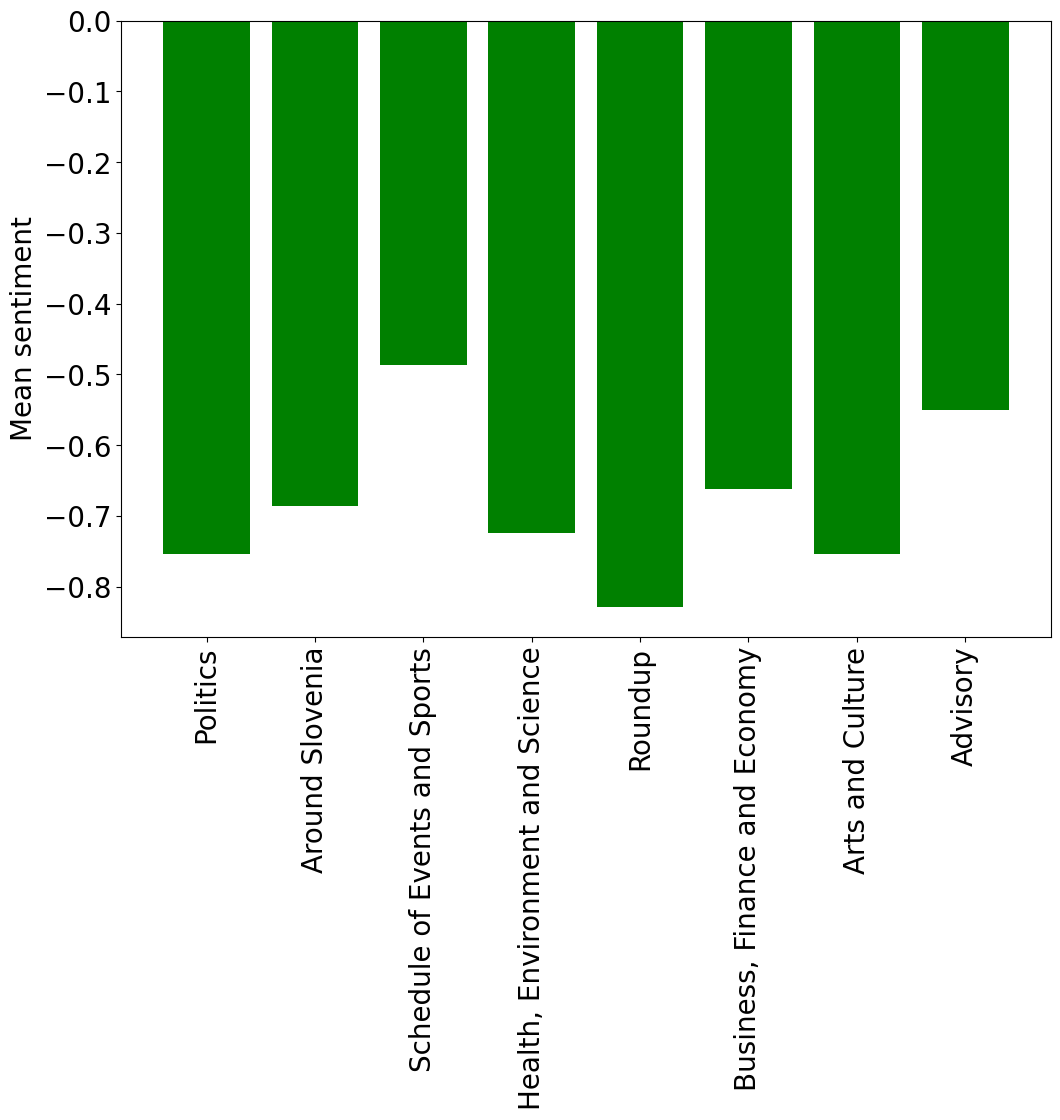

In [88]:
plot_sentiment(negative_sentiment_dict)

## Ada embedding visualization

Final latent space of semantic meaning of articles, computed with Ada embeddings and compressed to 3 dimensions with PCA.

In [97]:
from sklearn.decomposition import PCA
import pylab

In [98]:
labels = full_df['high_label']
embeddings = full_df['ada_embedding'].apply(eval)
embeddings = np.array(embeddings.tolist())


In [99]:
cat_df = pd.read_csv('data\\taxonomy.csv')
cat_df = cat_df[cat_df['hierarchy'] == 1]
cat_embeddings = cat_df['ada_embedding'].apply(eval)
cat_embeddings = np.array(cat_embeddings.tolist())
unique_labels = cat_df['name']

In [100]:
concat_embeddings = np.concatenate((embeddings, cat_embeddings), axis=0)    
reduced_embeddings = PCA(n_components=3).fit_transform(concat_embeddings)
reduced_embeddings, cat_embeddings = reduced_embeddings[:len(embeddings)], reduced_embeddings[len(embeddings):]
unique_labels = cat_df['name']

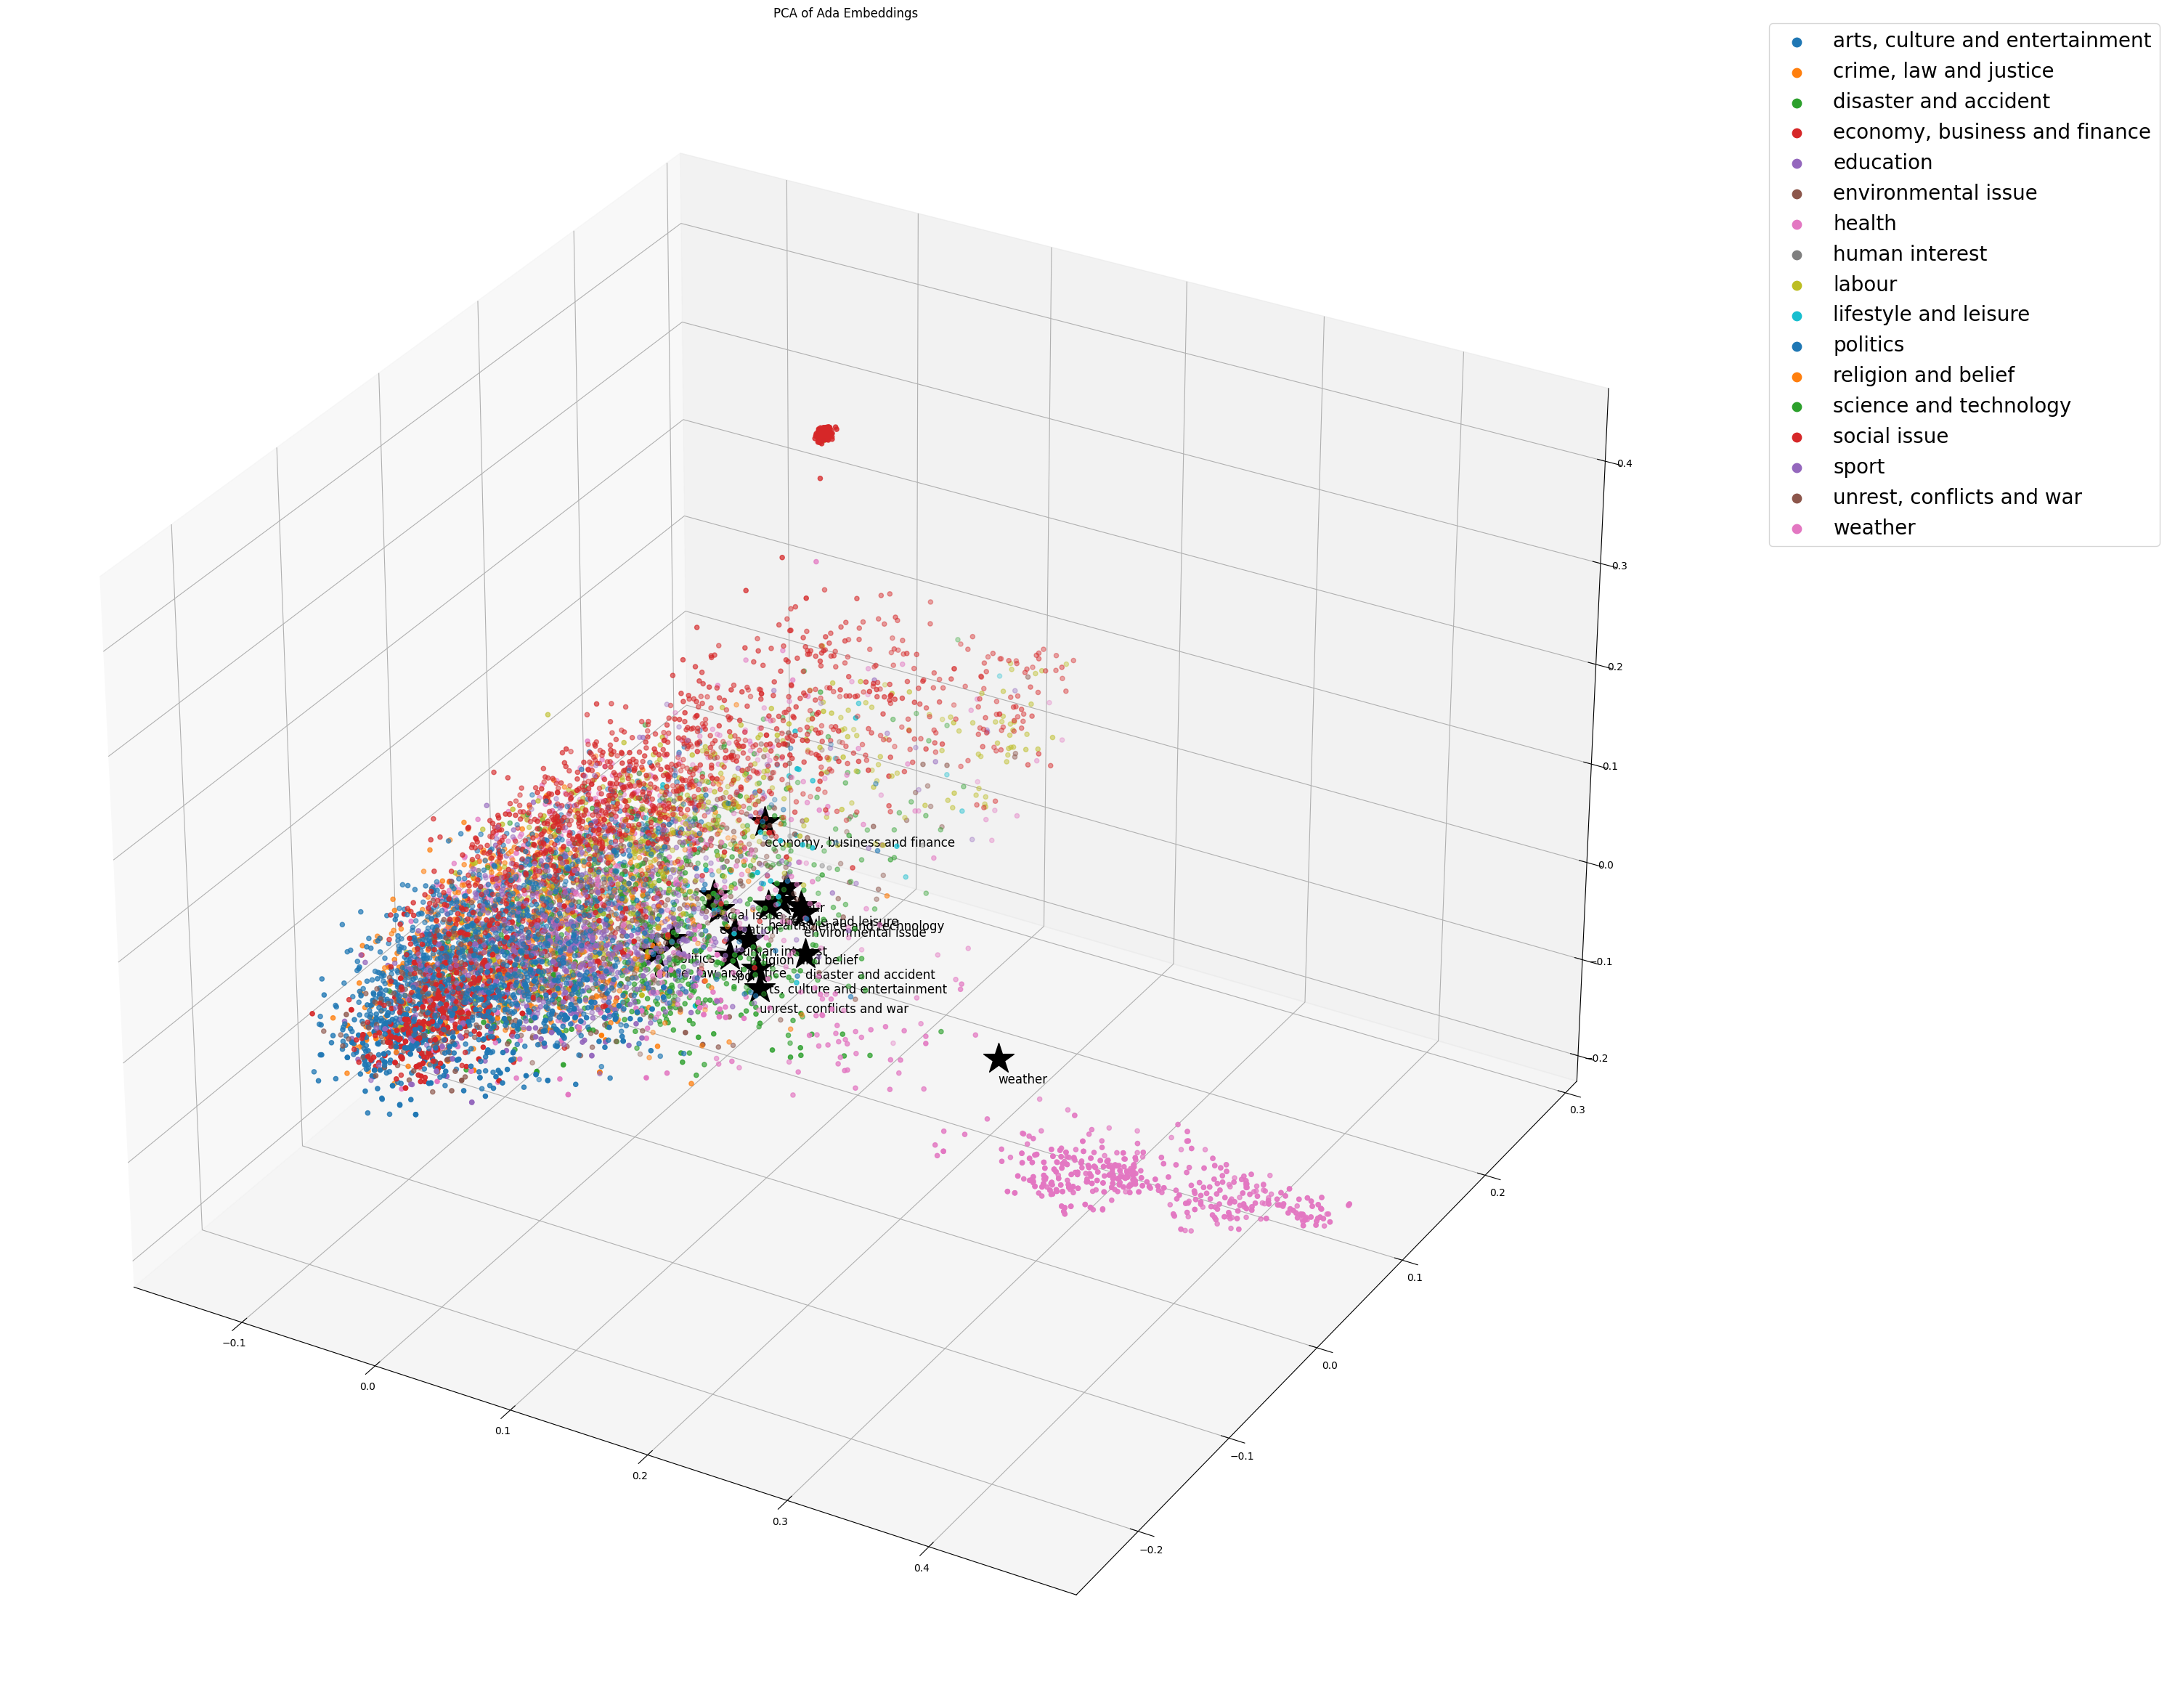

In [103]:
fig = pylab.figure(figsize=(30, 30))
ax = fig.add_subplot(111, projection='3d')

for label in unique_labels:
    indices = np.where(unique_labels == label)
    ax.scatter(cat_embeddings[indices, 0], cat_embeddings[indices, 1], cat_embeddings[indices, 2], s=1000, marker='*', color='black')
for i, label in enumerate(unique_labels):
    indices = np.where(labels == label)
    ax.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], reduced_embeddings[indices, 2], label=label)
    ax.text(cat_embeddings[i, 0], cat_embeddings[i, 1], cat_embeddings[i, 2] - 0.025, label, size=12, zorder=1, color='k')
    


ax.set_title('PCA of Ada Embeddings')
ax.legend()
ax.set_xlim(min(reduced_embeddings[:, 0]), max(reduced_embeddings[:, 0]))
ax.set_ylim(min(reduced_embeddings[:, 1]), max(reduced_embeddings[:, 1]))
ax.set_zlim(min(reduced_embeddings[:, 2]), max(reduced_embeddings[:, 2]))
# position legend outside of plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20, markerscale=2)
plt.show()